In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import re
from scipy import sparse
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.utils import shuffle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
style.use("fivethirtyeight")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text Processing

In [2]:
df1 = pd.read_csv("https://drive.google.com/uc?id=1OwvLZSYhmeNHJiI1XsYCfBH7fCC9Fmnn")
df2 = pd.read_csv("https://drive.google.com/uc?id=16t4ex87G38xDey4y-ARMdWQCct1_2THI")
df3 = pd.read_csv("https://drive.google.com/uc?id=10GJXvTzKo6sOXo-a60cAvMb_6jePtIId")
df4 = pd.read_csv("https://drive.google.com/uc?id=161Q3JF7HbYQIBCJD-s420mdWyqKh9vy1")
df5 = pd.read_csv("https://drive.google.com/uc?id=1Yj0gma0e7fHPmnYDJUalqBqsXKFTNzf4")

In [3]:
df_all = [df1, df2, df3, df4, df5]

In [4]:
df = pd.concat(df_all)

In [5]:
df = shuffle(df)

In [6]:
df.head()

,headlines,description,content,url,category
886,Sunny Deol talks about his equation with Shah ...,Sunny Deol and Juhi Chawla looked back on Darr...,While his equation with Shah Rukh Khan has mat...,https://indianexpress.com/article/entertainmen...,entertainment
1749,Sania Mirza and Rohan Bopanna lose mixed doubl...,"The Indian pair were defeated 6-7 (2), 2-6 by ...","In the final Grand Slam event of her career, S...",https://indianexpress.com/article/sports/tenni...,sports
1378,Air India launches 4-day sale on flights acros...,Air India is offering fares starting from Rs 1...,Tata Group-owned Air India has launched a four...,https://indianexpress.com/article/business/avi...,business
1139,Women’s T20 World Cup awaits another chapter i...,The neighbours have faced off on six occasions...,"Whatever anyone says, an India-Pakistan encoun...",https://indianexpress.com/article/sports/crick...,sports
1855,Jio announces 6 new prepaid plans with Disney+...,"With the right recharge plans, Jio allows prep...",Jio has announced six new prepaid subscription...,https://indianexpress.com/article/technology/t...,technology


In [7]:
df.reset_index(inplace= True, drop= True)

In [8]:
df['Text'] = df['headlines'] + df['description'] +df['content']

In [9]:
df.drop(['headlines', 'description', 'content'], axis = 1, inplace = True)

In [10]:
df.drop('url', axis = 1, inplace = True)

In [11]:
x = df['Text']
y = df['category']

In [12]:
df['category'].value_counts()

,count
category,
entertainment,2000
sports,2000
business,2000
technology,2000
education,2000


In [13]:
stop_words = stopwords.words('english')
#lemma
lemmer=WordNetLemmatizer()
corpus =[' '.join([lemmer.lemmatize(word) for word in text.split(' ')])
        for text in x]
corpus = [' '.join([word for word in text.split('\n')]) for text in corpus]
# Vector hóa từ sử dụng bag of word và TF-IDF
# tfidf = TfidfVectorizer(stop_words=stop_words).fit(raw_documents=corpus)
# bow = CountVectorizer(stop_words=stop_words).fit(raw_documents=corpus)
# bowdata = bow.transform(corpus)
# tfidfdata = tfidf.transform(corpus)


In [14]:


class Bow_lib():
    def __init__(self, stop_words=None):
        """
        Parameters:
        -----------
        stop_words : list or None
            List of stop words to remove from text
        """
        self.stop_words = stop_words
        self.vocabulary_ = {}
        self.is_fitted = False

        # Add token pattern similar to CountVectorizer
        self.token_pattern = r"(?u)\b\w\w+\b"


    def _sort_features(self, X, vocabulary):
        """Sort features by name

        Returns a reordered matrix and modifies the vocabulary in place
        """
        sorted_features = sorted(vocabulary.items())
        map_index = np.empty(len(sorted_features), dtype=X.indices.dtype)
        for new_val, (term, old_val) in enumerate(sorted_features):
            vocabulary[term] = new_val
            map_index[old_val] = new_val

        X.indices = map_index.take(X.indices, mode="clip")
        return X


    def _count_vocab(self, raw_documents, fixed_vocab):
        """Create sparse feature matrix, and vocabulary where fixed_vocab=False"""
        if fixed_vocab:
            vocabulary = self.vocabulary_
        else:
            # Add a new value when a new vocabulary item is seen
            vocabulary = defaultdict()
            vocabulary.default_factory = vocabulary.__len__

        j_indices = []
        indptr = []

        # values = np.zeros(0, dtype=int)
        values = []
        indptr.append(0)
        for doc in raw_documents:
            feature_counter = {}
            for feature in self.analyze(doc):
                try:
                    feature_idx = vocabulary[feature]
                    if feature_idx not in feature_counter:
                        feature_counter[feature_idx] = 1
                    else:
                        feature_counter[feature_idx] += 1
                except KeyError:
                    # Ignore out-of-vocabulary items for fixed_vocab=True
                    continue

            j_indices.extend(feature_counter.keys())
            values.extend(feature_counter.values())
            indptr.append(len(j_indices))
        values = np.array(values)

        if not fixed_vocab:
            # disable defaultdict behaviour
            vocabulary = dict(vocabulary)
            if not vocabulary:
                raise ValueError(
                    "empty vocabulary; perhaps the documents only contain stop words"
                )

        if indptr[-1] > np.iinfo(np.int32).max:  # = 2**31 - 1
            indices_dtype = np.int64
        else:
            indices_dtype = np.int32
        j_indices = np.asarray(j_indices, dtype=indices_dtype)
        indptr = np.asarray(indptr, dtype=indices_dtype)
        # values = np.frombuffer(values, dtype=np.intc)

        X = sparse.csr_matrix(
            (values, j_indices, indptr),
            shape=(len(indptr) - 1, len(vocabulary)),
            dtype=indices_dtype,
        )
        X.sort_indices()
        return vocabulary, X

    def fit(self, raw_documents, y=None):

        self.fit_transform(raw_documents)
        self.is_fitted = True
        return self

    def fit_transform(self, raw_documents, y=None):


        # We intentionally don't call the transform method to make
        # fit_transform overridable without unwanted side effects in
        # TfidfVectorizer.
        if isinstance(raw_documents, str):
            raise ValueError(
                "Iterable over raw text documents expected, string object received."
            )

        vocabulary, X = self._count_vocab(raw_documents, self.is_fitted)


        if not self.is_fitted:
                X = self._sort_features(X, vocabulary)
                self.vocabulary_ = vocabulary

        return X

    def transform(self, raw_documents):

        if isinstance(raw_documents, str):
            raise ValueError(
                "Iterable over raw text documents expected, string object received."
            )
        if not self.is_fitted:
            raise ValueError(
                "Not fit"
            )
        # use the same matrix-building strategy as fit_transform
        _, X = self._count_vocab(raw_documents, fixed_vocab=True)

        return X

    def inverse_transform(self, X):

        # We need CSR format for fast row manipulations.

        n_samples = X.shape[0]

        terms = np.array(list(self.vocabulary_.keys()))
        indices = np.array(list(self.vocabulary_.values()))
        inverse_vocabulary = terms[np.argsort(indices)]

        if sparse.issparse(X):
            return [
                inverse_vocabulary[X[i, :].nonzero()[1]].ravel()
                for i in range(n_samples)
            ]
        else:
            return [
                inverse_vocabulary[np.flatnonzero(X[i, :])].ravel()
                for i in range(n_samples)
            ]

    def get_feature_names_out(self, input_features=None):
        if not self.is_fitted:
            raise ValueError("Model must be fitted before getting feature names")
        return np.asarray(
            [t for t, i in sorted(self.vocabulary_.items(), key=lambda x: x[1])],
            dtype=object,
        )

    def analyze(self, text):
        """Helper method to tokenize text with improved preprocessing"""
        # Convert to lowercase
        text = text.lower()

        white_spaces = re.compile(r"\s\s+")

        text = white_spaces.sub(" ", text)

        token_pattern = re.compile(self.token_pattern)

        words = token_pattern.findall(text)

        # Find all words that match the pattern (at least 2 letters)
        #words = re.findall(self.token_pattern, text)

        # Remove stop words if any
        if self.stop_words:
            words = [w for w in words if w not in self.stop_words]

        return words




In [15]:
class Tfidf_lib():
    def __init__(self, stop_words=None):
        """
        Parameters:
        -----------
        stop_words : list or None
            List of stop words to remove from text
        """
        self.stop_words = stop_words
        self.vocabulary_ = {}
        self.idf_ = None
        self.is_fitted = False

    def _normalize(self, X):
        """Apply L2 normalization to sparse matrix X."""
        norm = sparse.linalg.norm(X, axis=1)
        norm[norm == 0] = 1
        norm_diag = sparse.spdiags(1 / norm, diags=0, m=X.shape[0], n=X.shape[0])
        return norm_diag.dot(X)

    def fit(self, raw_documents, y=None):
        """Fit the model to the documents."""
        self.fit_transform(raw_documents)
        return self

    def fit_transform(self, raw_documents, y=None):
        """Transform raw documents into feature matrix with TF-IDF weighting."""
        bowdata = self._bow_transform(raw_documents)
        n_samples, n_features = bowdata.shape
        df = np.bincount(bowdata.indices, minlength=n_features)
        self.idf_ = np.log((n_samples + 1) / (df + 1)) + 1  # Điều chỉnh công thức IDF
        idf_diag = sparse.spdiags(self.idf_, diags=0, m=n_features, n=n_features)
        X = bowdata.dot(idf_diag)
        X = self._normalize(X)
        self.is_fitted = True
        return X


    def transform(self, raw_documents):
        """Transform raw documents into feature matrix using TF-IDF."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before transforming.")
        bowdata = self._bow_transform(raw_documents)
        n_features = len(self.vocabulary_)
        idf_diag = sparse.spdiags(self.idf_, diags=0, m=n_features, n=n_features)
        X = bowdata.dot(idf_diag)
        X = self._normalize(X)
        return X

    def get_feature_names_out(self, input_features=None):
        """Return the feature names (words) from the vocabulary."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before getting feature names")
        return np.asarray([t for t, i in sorted(self.vocabulary_.items(), key=lambda x: x[1])], dtype=object)

    def _bow_transform(self, raw_documents):
        """Convert documents to a Bag-of-Words representation."""
        # Convert documents to tokenized form
        corpus = [self.analyze(doc) for doc in raw_documents]

        # Use existing vocabulary if fitted, otherwise create new one
        if self.is_fitted:
            vocabulary = self.vocabulary_
        else:
            vocabulary = {}

        j_indices = []
        indptr = [0]
        values = []

        for doc in corpus:
            feature_counter = {}
            for feature in doc:
                # Only use features that exist in the vocabulary when transforming
                if self.is_fitted:
                    if feature not in vocabulary:
                        continue
                    feature_idx = vocabulary[feature]
                else:
                    feature_idx = vocabulary.get(feature, len(vocabulary))
                    if feature not in vocabulary:
                        vocabulary[feature] = feature_idx

                if feature_idx not in feature_counter:
                    feature_counter[feature_idx] = 1
                else:
                    feature_counter[feature_idx] += 1

            j_indices.extend(feature_counter.keys())
            values.extend(feature_counter.values())
            indptr.append(len(j_indices))

        values = np.array(values)
        j_indices = np.asarray(j_indices, dtype=np.int32)
        indptr = np.asarray(indptr, dtype=np.int32)

        # Use the correct vocabulary size for the matrix shape
        vocab_size = len(self.vocabulary_) if self.is_fitted else len(vocabulary)
        X = sparse.csr_matrix(
            (values, j_indices, indptr),
            shape=(len(indptr) - 1, vocab_size)
        )
        X.sort_indices()

        # Only update vocabulary during fit
        if not self.is_fitted:
            self.vocabulary_ = vocabulary

        return X

    def analyze(self, text):
        """Helper method to tokenize text with improved preprocessing."""
        text = text.lower()
        white_spaces = re.compile(r"\s\s+")
        text = white_spaces.sub(" ", text)
        token_pattern = re.compile(r"(?u)\b\w\w+\b")
        words = token_pattern.findall(text)
        if self.stop_words:
            words = [w for w in words if w not in self.stop_words]
        return words


In [16]:
tfidf = Tfidf_lib(stop_words=stop_words).fit(corpus)
bow = Bow_lib(stop_words=stop_words).fit(corpus)
# tfidf = TfidfVectorizer(stop_words=stop_words, max_features=30000).fit(corpus)
# bow = CountVectorizer(stop_words=stop_words, max_features=30000).fit(corpus)
bowdata = bow.transform(corpus)
tfidfdata = tfidf.transform(corpus)


# Mô hình  Latent Dirichlet Allocation

In [17]:
lda = LatentDirichletAllocation(n_components= y.nunique(), random_state=11, learning_method="online")

In [18]:
bowdist = lda.fit_transform(bowdata)
tfidfdist = lda.fit_transform(tfidfdata)

In [19]:
bowdist = np.argmax(bowdist, axis=1)
tfidfdist = np.argmax(tfidfdist, axis=1)

In [20]:
#realtopic=y.idxmax(axis=1)

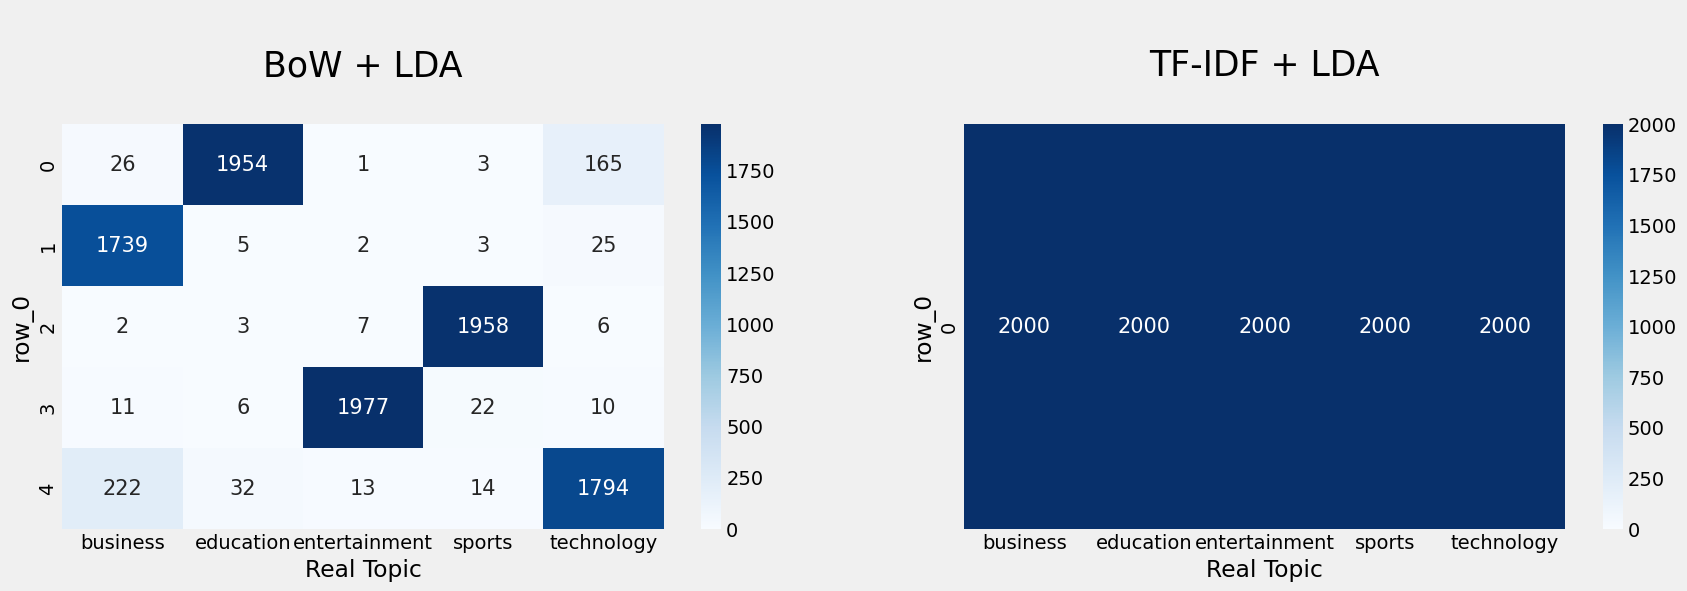

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,5))

sns.heatmap(pd.crosstab(bowdist, y), annot=True, fmt="d", annot_kws={"fontsize":15}, cmap="Blues", vmin=0, ax=axes[0])
axes[0].set_xlabel("Real Topic")
axes[0].set_title("\nBoW + LDA\n", fontsize=25)

sns.heatmap(pd.crosstab(tfidfdist, y), annot=True, fmt="d", annot_kws={"fontsize":15}, cmap="Blues", vmin=0, ax=axes[1])
axes[1].set_xlabel("Real Topic")
axes[1].set_title("\nTF-IDF + LDA\n", fontsize=25)

plt.show()

# Mô hình Non-negative Matrix Factorization

In [22]:
nnm = NMF(n_components= y.nunique(), random_state=42)

In [23]:
wbow = nnm.fit_transform(bowdata)
wtfidf = nnm.fit_transform(tfidfdata)

In [24]:
wbow = np.argmax(wbow, axis=1)
wtfidf = np.argmax(wtfidf, axis=1)

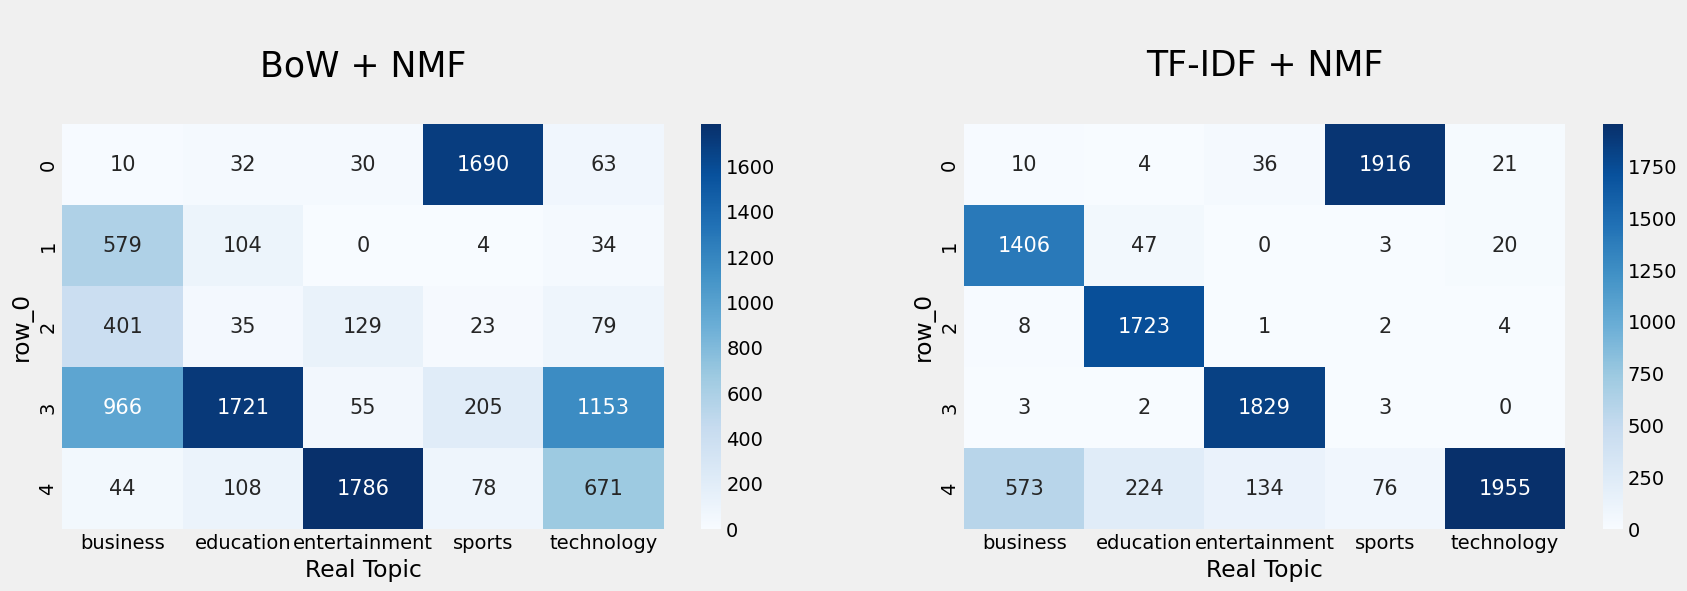

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,5))

sns.heatmap(pd.crosstab(wbow, y), annot=True, fmt="d", annot_kws={"fontsize":15}, cmap="Blues", vmin=0, ax=axes[0])
axes[0].set_xlabel("Real Topic")
axes[0].set_title("\nBoW + NMF\n", fontsize=25)

sns.heatmap(pd.crosstab(wtfidf, y), annot=True, fmt="d", annot_kws={"fontsize":15}, cmap="Blues", vmin=0, ax=axes[1])
axes[1].set_xlabel("Real Topic")
axes[1].set_title("\nTF-IDF + NMF\n", fontsize=25)

plt.show()

# Lưu mô hình

In [28]:
lda_save = LatentDirichletAllocation(n_components= y.nunique(), random_state=11, learning_method="online")
nmf_save = NMF(n_components= y.nunique(), random_state=42)

In [29]:
lda_save.fit(bowdata)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=11)

In [30]:
nmf_save.fit(tfidfdata)

NMF(n_components=5, random_state=42)

In [31]:
import joblib

# Lưu mô hình
joblib.dump(lda_save, 'lda_model.pkl')
joblib.dump(nmf_save, 'nmf_model.pkl')

# Lưu vectorizer
joblib.dump(bow, 'vectorizer_lda.pkl')
joblib.dump(tfidf, 'vectorizer_nmf.pkl')

print("Model và vectorizer đã được lưu thành công!")


Model và vectorizer đã được lưu thành công!
